# Medical Image Segmentation
In this practice, we will do chest X-ray segmentation for the Shenzhen hospital data using the U-Net architecture.

**Task**: Semantic binary segmentation; if the pixel is corresponding to lung location (1) or not (0)

**Data**: Shenzhen hospital data

**Model**: U-Net

**Framework**: Pytorch

## About dataset: The Shenzhen set

* The standard digital image database for Tuberculosis.
* Provided by the National Library of Medicine, Maryland, USA in collaboration with Shenzhen No.3 People’s Hospital, Guangdong Medical College, Shenzhen, China.
* The dataset contains x-rays and corresponding segmented masks for lungs.
* Some masks are missing so it is advised to cross-reference the images and masks.
* For more detail, visit here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4256233/

## Data preprocessing

For simple use, images and masks were preprocessed by TA.
* Used images that have corresponding masks.
* Used 20% of training data as validation and test data. (10% each)

## Mount Your Google Drive

- **First, set proper runtime. (Python3 & GPU)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import modules

In [2]:
import os
import csv
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from pathlib import Path

import torch
import torch.optim as optim

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import save_image

from torchsummary import summary

## Data paths and hyperparameters

In [3]:
# train: 452
TRAIN_IMG_PATH = "/content/drive/MyDrive/Coursework/GCDA_24F/6_Image/DATA/CHNCXR/train_CXR_png"
TRAIN_MASK_PATH = "/content/drive/MyDrive/Coursework/GCDA_24F/6_Image/DATA/CHNCXR/train_masks"

# valid: 57
VALID_IMG_PATH = "/content/drive/MyDrive/Coursework/GCDA_24F/6_Image/DATA/CHNCXR/valid_CXR_png"
VALID_MASK_PATH = "/content/drive/MyDrive/Coursework/GCDA_24F/6_Image/DATA/CHNCXR/valid_masks"

# test: 57
TEST_IMG_PATH = "/content/drive/MyDrive/Coursework/GCDA_24F/6_Image/DATA/CHNCXR/test_CXR_png"
TEST_MASK_PATH = "/content/drive/MyDrive/Coursework/GCDA_24F/6_Image/DATA/CHNCXR/test_masks"

# hyperparameters
IMAGE_SIZE = 512
BATCH_SIZE = 16
EPOCHS = 200
RESULTS_FOLDER = "/content/drive/MyDrive/Coursework/GCDA_24F/6_Image/results_seg/"

os.mkdir(RESULTS_FOLDER) if not os.path.exists(RESULTS_FOLDER) else None

## Define custom dataset class

In [4]:
class CXR_Seg_Dataset(Dataset):
    def __init__(self, image_path, mask_path, image_size):
        super(CXR_Seg_Dataset, self).__init__()
        self.image_path = image_path
        self.mask_path = mask_path

        self.mask_names = os.listdir(mask_path)
        self.image_names = os.listdir(image_path)

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.image_names[index]
        mask_name = self.mask_names[index]

        image = Image.open(os.path.join(self.image_path, image_name)).convert("L")
        mask = Image.open(os.path.join(self.mask_path, mask_name)).convert("L")

        return self.transform(image), self.transform(mask)

## Define dataset and dataloader

In [5]:
train_dataset = CXR_Seg_Dataset(TRAIN_IMG_PATH, TRAIN_MASK_PATH, IMAGE_SIZE)
valid_dataset = CXR_Seg_Dataset(VALID_IMG_PATH, VALID_MASK_PATH, IMAGE_SIZE)
test_dataset = CXR_Seg_Dataset(TEST_IMG_PATH, TEST_MASK_PATH, IMAGE_SIZE)

print("Data Information")
print("    Train data:", len(train_dataset))
print("    Valid data:", len(valid_dataset))
print("    Test data:", len(test_dataset))

dataloader_train = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=2, pin_memory=True)
dataloader_valid = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=2, pin_memory=True)
dataloader_test = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=2, pin_memory=True)

Data Information
    Train data: 452
    Valid data: 57
    Test data: 57


## Data sanity check

In [6]:
def plot_mask(intput, target):
    sample = []
    for i in range(2):
        combined = np.hstack((intput[i].permute(1, 2, 0), target[i].permute(1, 2, 0)))
        sample.append(combined)

    plt.figure(figsize=(12, 6))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(sample[i], cmap="gray")
        plt.axis("off")
    plt.show()

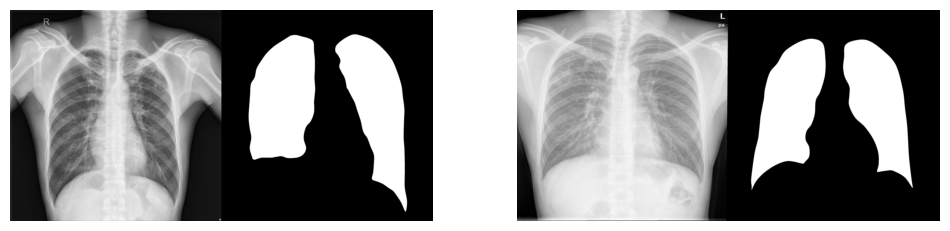

In [7]:
input, target = next(iter(dataloader_train)) # dataloader_valid # dataloader_test
plot_mask(input, target)

# Define U-Net model class

<img src="https://drive.google.com/uc?id=1iCBfTlTHv870VZVNNNOHqeNCYR54fVQq" width=600px>
<figcaption align = "left">image source: https://arxiv.org/abs/1505.04597</figcaption>

In [8]:
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding="same"),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.downsample(x)
        return x

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(2,2), stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding="same"),
            nn.ReLU(),
        )

    def forward(self, x1, x2):
        x = torch.cat((self.upsample(x1), x2), axis=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.down1 = Downsample(in_channels, 32)
        self.down2 = Downsample(32, 64)
        self.down3 = Downsample(64, 128)
        self.down4 = Downsample(128, 256)

        self.down5 = Downsample(256, 512)

        self.up1 = Upsample(512, 256)
        self.up2 = Upsample(256, 128)
        self.up3 = Upsample(128, 64)
        self.up4 = Upsample(64, 32)

        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.convfinal = nn.Conv2d(32, out_channels, kernel_size=(1,1), stride=1, padding="valid")
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1_1 = self.down1(x)
        x1_2 = self.maxpool(x1_1)
        x2_1 = self.down2(x1_2)
        x2_2 = self.maxpool(x2_1)
        x3_1 = self.down3(x2_2)
        x3_2 = self.maxpool(x3_1)
        x4_1 = self.down4(x3_2)
        x4_2 = self.maxpool(x4_1)

        x5 = self.down5(x4_2)

        x = self.up1(x5, x4_1)
        x = self.up2(x, x3_1)
        x = self.up3(x, x2_1)
        x = self.up4(x, x1_1)

        x = self.convfinal(x)
        x = self.sigmoid(x)

        return x

## Define model and optimizer

In [9]:
model = UNet(in_channels=1, out_channels=1).cuda()
#model = torch.nn.DataParallel(model).cuda() # use with multi-gpu environment
summary(model, input_size=(1, 512, 512), device="cuda")

optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3,
                                                 verbose=1, eps=1e-04, cooldown=2, min_lr=1e-6)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
              ReLU-2         [-1, 32, 512, 512]               0
            Conv2d-3         [-1, 32, 512, 512]           9,248
              ReLU-4         [-1, 32, 512, 512]               0
        Downsample-5         [-1, 32, 512, 512]               0
         MaxPool2d-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 64, 256, 256]          18,496
              ReLU-8         [-1, 64, 256, 256]               0
            Conv2d-9         [-1, 64, 256, 256]          36,928
             ReLU-10         [-1, 64, 256, 256]               0
       Downsample-11         [-1, 64, 256, 256]               0
        MaxPool2d-12         [-1, 64, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]          73,856
             ReLU-14        [-1, 128, 1

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Define trainer

In [10]:
class CXR_Seg_Trainer():
    def __init__(
        self,
        model,
        results_folder,
        dataloader_train,
        dataloader_valid,
        dataloader_test,
        epochs,
        optimizer,
        scheduler,
    ):
        super(CXR_Seg_Trainer, self).__init__()

        self.model = model
        self.dataloader_train = dataloader_train
        self.dataloader_valid = dataloader_valid
        self.dataloader_test = dataloader_test
        self.epoch = 0
        self.epochs = epochs
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok=True)

    def train(self):
        print("[ Start training ]")
        self.model.train()
        valid_loss_min = 10000
        train_dice_list, valid_dice_list = [], []

        while self.epoch < self.epochs:
            print(f"\nEpoch {self.epoch:3d}: training")
            train_loss_sum = 0
            for _, (input, target) in enumerate(tqdm(self.dataloader_train)):
                input = input.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)

                output = self.model(input)

                loss = self.dice_coef_loss(output, target)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                train_loss_sum += loss.item()*input.size(0)

            train_loss_avg = train_loss_sum / len(self.dataloader_train.dataset)
            train_dice_list.append(-1*train_loss_avg)

            # validation step
            print(f"\nEpoch {self.epoch:3d}: validation")
            self.model.eval()
            with torch.no_grad():
                valid_loss_sum = 0
                for _, (input, target) in enumerate(tqdm(self.dataloader_valid)):
                    input = input.cuda(non_blocking=True)
                    target = target.cuda(non_blocking=True)

                    output = self.model(input)

                    loss = self.dice_coef_loss(output, target)

                    valid_loss_sum += loss.item()*input.size(0)

                valid_loss_avg = valid_loss_sum / len(self.dataloader_valid.dataset)
                valid_dice_list.append(-1*valid_loss_avg)
                self.scheduler.step(valid_loss_avg)
                print(f"    Epoch {self.epoch:2d}: training loss = {train_loss_avg:.3f} / validation loss = {valid_loss_avg:.3f}")

                # save model if better validation loss
                if valid_loss_sum < valid_loss_min:
                    valid_loss_min = valid_loss_sum
                    self.save(self.epoch)
                    print(f"    Saved model: unet-{self.epoch}.pth.tar")

            self.epoch += 1
        print("[ End training ]")
        return train_dice_list, valid_dice_list

    def test(self):
        print("[ Start test ]")
        self.model.eval()
        with torch.no_grad():
            test_loss_sum = 0
            for i, (input, target) in enumerate(tqdm(self.dataloader_test)):
                input = input.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)

                output = self.model(input)

                loss = self.dice_coef_loss(output, target)

                test_loss_sum += loss.item()*input.size(0)
                # save output and compare it to target
                if i < 3:
                    save_image(input.cpu(), os.path.join(self.results_folder, f"test{i}_input.png"))
                    save_image(target.cpu(), os.path.join(self.results_folder, f"test{i}_target.png"))
                    save_image(output.cpu(), os.path.join(self.results_folder, f"test{i}_output.png"))
            test_loss_avg = test_loss_sum / len(self.dataloader_test.dataset)
            print(f"    test loss = {test_loss_avg:.3f}")
            print(f"    Dice coefficient = {-1.*test_loss_avg:.3f}")
        print("[ End test ]")

        for i in range(0, 9, 3):
            plt.subplot(3, 3, i+1)
            img_input = plt.imread(os.path.join(RESULTS_FOLDER, f"test{int(i//3)}_input.png"))
            plt.imshow(img_input, cmap="gray")
            plt.xlabel("Base Image")

            plt.subplot(3, 3, i+2)
            img_target = plt.imread(os.path.join(RESULTS_FOLDER, f"test{int(i//3)}_target.png"))
            plt.imshow(img_target, cmap="gray")
            plt.xlabel("Mask")

            plt.subplot(3, 3, i+3)
            img_output = plt.imread(os.path.join(RESULTS_FOLDER, f"test{int(i//3)}_output.png"))
            plt.imshow(img_output, cmap="gray")
            plt.xlabel("Prediction")

            plt.show()
        plt.savefig(os.path.join(RESULTS_FOLDER, "test_examples.png"))
        plt.close()

    def dice_coef(self, y_true, y_pred):
        y_true_f = torch.flatten(y_true)
        y_pred_f = torch.flatten(y_pred)
        intersection = torch.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + 1)

    def dice_coef_loss(self, y_true, y_pred):
        return -self.dice_coef(y_true, y_pred)

    def save(self, milestone):
        files = os.listdir(self.results_folder)
        remove = [f for f in files if ".pth.tar" in f]
        if len(remove) > 0:
            os.remove(os.path.join(self.results_folder, remove[0]))
        torch.save({"epoch": milestone,
                    "state_dict": self.model.state_dict(),
                    "optimizer" : self.optimizer.state_dict()},
                    f"{self.results_folder}/unet-{milestone}.pth.tar")

    def load(self, milestone):
        checkpoint = torch.load(f"{self.results_folder}/unet-{milestone}.pth.tar")
        self.model.load_state_dict(checkpoint["state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        self.epoch = checkpoint["epoch"]

## Train the model

In [11]:
# init the trainer
trainer = CXR_Seg_Trainer(
    model,
    RESULTS_FOLDER,
    dataloader_train,
    dataloader_valid,
    dataloader_test,
    EPOCHS,
    optimizer,
    scheduler
)

In [12]:
train_start = time.time()
train_dice_list, valid_dice_list = trainer.train() # training!
train_end = time.time()
print(f"\nElapsed time: {(train_end - train_start) / 60:.0f} minutes")

[ Start training ]

Epoch   0: training


  7%|▋         | 2/29 [00:19<04:17,  9.52s/it]


KeyboardInterrupt: 

In [ ]:
# Plot the training and validation loss and accuracy
plt.plot(range(1, EPOCHS+1), train_dice_list, label="Training")
plt.plot(range(1, EPOCHS+1), valid_dice_list, label="Validation")
plt.title("Training and Validation Dice Coefficient")
plt.xlabel("Epochs")
plt.xticks(np.arange(0, EPOCHS+1, 5))
plt.ylabel("Dice Coefficient")
plt.legend(loc="best")
plt.show()
plt.savefig(os.path.join(RESULTS_FOLDER, "dice_plot.png"))
plt.close()

<img src="https://drive.google.com/uc?id=1OlDau654MD9czh8ZJXbuif6zQEVbJvN4" width=600px>

# Test the model

In [ ]:
trainer.load(199) # 0.929
trainer.test()

<img src="https://drive.google.com/uc?id=1AwlhbRzGRRccaK0mPBD7W-5xgANjK3jF" width=600px>